In [1]:
import pandas as pd
from typing import Tuple
import anndata
from malid import config, io, helpers, logger
from malid.datamodels import (
    GeneLocus,
    TargetObsColumnEnum,
    map_cross_validation_split_strategy_to_default_target_obs_column,
    healthy_label,
)
from malid.trained_model_wrappers import ConvergentClusterClassifier
from IPython.display import display, Markdown

pd.set_option("display.max_columns", None)

In this notebook, we:

1. Check how many BCR Covid-19 clusters Model 2 identifies in the global fold.
2. Check how many of the unique sequences in the CoV-AbDab external dataset are matched to a Model 2 Covid-19 cluster. Matching requires having an identical V gene, J gene, and CDR3 length, and having a CDR3 region with at least 85% sequence identity.

_This notebook is based on `notebooks/ranks_of_known_binders_vs_healthy_donor_sequences.ipynb`_

In [2]:
# We only support split strategies with default target obs column == TargetObsColumnEnum.disease
assert (
    map_cross_validation_split_strategy_to_default_target_obs_column[
        config.cross_validation_split_strategy
    ]
    == TargetObsColumnEnum.disease
)

In [3]:
def extract_disease_cluster_list(clf: ConvergentClusterClassifier, disease: str):
    # Get all clusters
    model2_cluster_class_associations = (
        clf.cluster_centroids_with_class_specific_p_values
    )

    # Melt to columns = [cluster_dominant_label, p_value], but first move consensus_sequence into the set of index columns
    # TODO(refactor): this reset_index().set_index() operation is quite slow
    model2_cluster_class_associations = (
        model2_cluster_class_associations.reset_index()
        .set_index(
            list(model2_cluster_class_associations.index.names) + ["consensus_sequence"]
        )
        .melt(
            # preserve index
            ignore_index=False,
            var_name="cluster_dominant_label",
            value_name="p_value",
        )
    )

    # Filter to clusters associated with each class
    model2_cluster_class_associations = model2_cluster_class_associations[
        model2_cluster_class_associations["p_value"] <= clf.p_value_threshold
    ]

    # Filter to Covid predictive cluster centroids only
    disease_clusters_from_model2 = model2_cluster_class_associations[
        model2_cluster_class_associations["cluster_dominant_label"] == disease
    ]

    return disease_clusters_from_model2

In [4]:
def score_sequences(adata, disease_clusters_from_model2, gene_locus):
    # Assign each test sequence to known cluster with nearest centroid, if possible
    df = ConvergentClusterClassifier._assign_sequences_to_known_clusters(
        df=adata.obs,
        cluster_centroids_by_supergroup=ConvergentClusterClassifier._wrap_cluster_centroids_as_dict_by_supergroup(
            disease_clusters_from_model2
        ),
        sequence_identity_threshold=config.sequence_identity_thresholds.assign_test_sequences_to_clusters[
            gene_locus
        ],
        validate_same_fold_id_and_label=False,
    )

    # Compute (1 - normalized Hamming distance) to get a proximity score.
    # Set to 0 if there were no centroids that could be compared to (i.e. no predictive clusers with same V/J/CDR3 length)
    df["centroid_proximity_score"] = 1 - df["distance_to_nearest_centroid"].fillna(1)

    return df

In [6]:
fold_id = -1
gene_locus = GeneLocus.BCR
target_obs_column = TargetObsColumnEnum.disease
sample_weight_strategy = config.sample_weight_strategy

In [7]:
clf_model2 = ConvergentClusterClassifier(
    fold_id=fold_id,
    model_name=config.metamodel_base_model_names.model_name_convergent_clustering[
        gene_locus
    ],
    fold_label_train="train_smaller1",
    gene_locus=gene_locus,
    target_obs_column=target_obs_column,
)
clf_model2

ConvergentClusterClassifier: Pipeline(steps=[('matchvariables', MatchVariables()),
                ('standardscalerthatpreservesinputtype',
                 StandardScalerThatPreservesInputType()),
                ('glmnetlogitnetwrapper',
                 GlmnetLogitNetWrapper(alpha=0, class_weight='balanced', cut_point=1.0, fit_intercept=True, internal_cv=StratifiedGroupKFoldRequiresGroups(n_splits=5, random_state=0, shuffle=True), lambda_path=None, lower_limits=-inf, max_features=None, max_iter=100000, min_lambda_ratio=0.0001, n_jobs=8, n_lambda=100, n_splits=5, random_state=0, require_cv_group_labels=True, scoring=<function GlmnetLogitNetWrapper.deviance_scorer at 0x7f6314e48dc0>, standardize=False, tol=1e-07, upper_limits=inf, use_lambda_1se=False, verbose=True))])

In [55]:
disease = "Covid19"
display(Markdown(f"## {gene_locus}, {disease}"))

# Extract list of predictive clusters from model 2
disease_associated_clusters_from_model2 = extract_disease_cluster_list(
    clf=clf_model2, disease=disease
)

# Load this locus's known binders
known_binders_adata = io.load_known_binder_embeddings(
    fold_id=fold_id,
    gene_locus=gene_locus,
    disease=disease,
    known_binder=True,
    sample_weight_strategy=sample_weight_strategy,
)
if gene_locus == GeneLocus.BCR:
    # set
    known_binders_adata.obs["isotype_supergroup"] = "IGHG"
else:
    known_binders_adata.obs["isotype_supergroup"] = "TCRB"


def _score_with_model2(ad: anndata.AnnData) -> Tuple[pd.DataFrame, float]:
    sequence_distances = score_sequences(
        ad, disease_associated_clusters_from_model2, gene_locus
    )

    # this proportion of sequences had no disease-predictive centroids to compare to,
    # and thus have centroid proximity score = 0.0 by default:
    unscored_sequences_proportion = (
        sequence_distances["distance_to_nearest_centroid"]
        .isna()
        .value_counts(normalize=True)
        .reindex([True, False])
        .loc[True]
    )

    return sequence_distances, unscored_sequences_proportion


# Score known binder sequences
(
    known_binder_sequence_distances,
    proportion_of_known_binder_sequences_with_no_disease_associated_centroids_for_comparison,
) = _score_with_model2(known_binders_adata)

## GeneLocus.BCR, Covid19

In [56]:
known_binders_adata.shape

(6468, 640)

In [57]:
known_binder_sequence_distances.shape

(6468, 38)

In [58]:
proportion_of_known_binder_sequences_with_no_disease_associated_centroids_for_comparison

0.7884972170686456

In [59]:
known_binder_sequence_distances["distance_to_nearest_centroid"].isna().value_counts()

True     5100
False    1368
Name: distance_to_nearest_centroid, dtype: int64

In [60]:
known_binder_sequence_distances["distance_to_nearest_centroid"].isna().value_counts(
    normalize=True
)

True     0.788497
False    0.211503
Name: distance_to_nearest_centroid, dtype: float64

In [61]:
known_binder_sequence_distances["distance_to_nearest_centroid"].describe()

count    1368.000000
mean        0.535788
std         0.187292
min         0.000000
25%         0.400000
50%         0.571429
75%         0.684211
max         1.000000
Name: distance_to_nearest_centroid, dtype: float64

<Axes: >

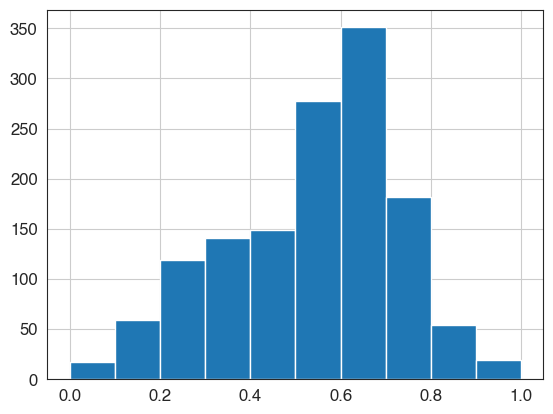

In [62]:
known_binder_sequence_distances["distance_to_nearest_centroid"].hist()

In [63]:
known_binder_sequence_distances["centroid_proximity_score"].isna().value_counts()

False    6468
Name: centroid_proximity_score, dtype: int64

In [64]:
known_binder_sequence_distances["centroid_proximity_score"].describe()

count    6468.000000
mean        0.098182
std         0.208226
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: centroid_proximity_score, dtype: float64

<Axes: >

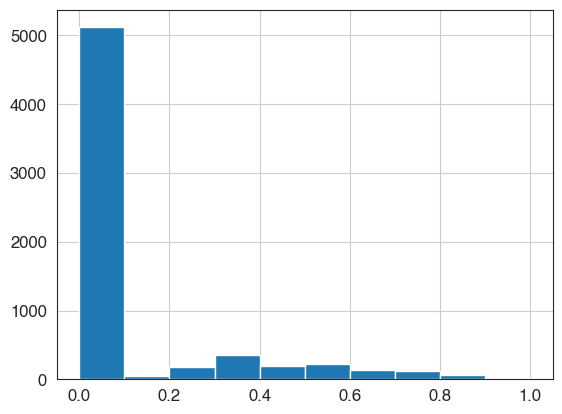

In [65]:
known_binder_sequence_distances["centroid_proximity_score"].hist()

In [ ]:
# How many matches:

In [66]:
(known_binder_sequence_distances["centroid_proximity_score"] >= 0.85).value_counts()

False    6431
True       37
Name: centroid_proximity_score, dtype: int64

In [67]:
known_binder_sequence_distances[
    known_binder_sequence_distances["centroid_proximity_score"] >= 0.85
]["v_gene"].value_counts()

IGHV3-33    11
IGHV1-58     7
IGHV3-30     5
IGHV3-53     4
IGHV3-66     3
IGHV3-7      2
IGHV1-24     2
IGHV3-9      1
IGHV4-39     1
IGHV3-74     1
Name: v_gene, dtype: int64

In [68]:
known_binder_sequence_distances[
    known_binder_sequence_distances["centroid_proximity_score"] >= 0.85
][["v_gene", "j_gene", "cdr3_seq_aa_q_trim"]].sort_values(["v_gene", "j_gene"])

,v_gene,j_gene,cdr3_seq_aa_q_trim
4891,IGHV1-24,IGHJ5,ATGPVRGVIGWFDP
5549,IGHV1-24,IGHJ6,ATGVAVAGTPINYYYYYGMDV
828,IGHV1-58,IGHJ3,AAPYCSSTNCYDAFDI
842,IGHV1-58,IGHJ3,AAPYCSRTSCHDAFDI
2054,IGHV1-58,IGHJ3,AAPYCSSTSCRDGFDI
5318,IGHV1-58,IGHJ3,AAPNCSGGSCYDAFDI
5745,IGHV1-58,IGHJ3,AAPYCSSTRCYDAFDI
5747,IGHV1-58,IGHJ3,AAPYCSSTTCHDGFDI
6424,IGHV1-58,IGHJ3,AAPHCSGGSCYDAFDI
2960,IGHV3-30,IGHJ3,AKSRSGSYLSAFDI


In [69]:
known_binder_sequence_distances["v_gene"].value_counts()

IGHV3-30        989
IGHV1-69        648
IGHV3-53        368
IGHV3-33        314
IGHV3-23        280
IGHV1-46        266
IGHV3-9         260
IGHV4-39        245
IGHV5-51        231
IGHV3-66        201
IGHV1-18        177
IGHV4-4         171
IGHV4-59        162
IGHV1-2         161
IGHV3-13        160
IGHV4-31        145
IGHV3-21        127
IGHV3-7         126
IGHV4-34        114
IGHV3-48        114
IGHV2-5         108
IGHV1-58         95
IGHV3-15         82
IGHV1-24         79
IGHV3-30-3       78
IGHV2-70         78
IGHV4-61         71
IGHV7-4-1        69
IGHV3-11         69
IGHV1-8          58
IGHV5-a          52
IGHV4-30-4       48
IGHV1-3          46
IGHV3-64D        44
IGHV3-49         40
IGHV3-20         32
IGHV3-74         23
IGHV4-b          22
IGHV3-43         22
IGHV4-30-2       17
IGHV2-26         15
IGHV6-1          14
IGHV2-70D        10
IGHV1-f           8
IGHV3-64          8
IGHV3-43D         6
IGHV3-73          5
IGHV3-72          5
IGHV1-45          2
IGHV4/OR15-8      2


In [70]:
disease_associated_clusters_from_model2

,,,,,cluster_dominant_label,p_value
v_gene,j_gene,cdr3_aa_sequence_trim_len,cluster_id_within_clustering_group,consensus_sequence,,
IGHV3-11,IGHJ6,17,664.0,ARDRGGSYGPYYYGMDV,Covid19,0.002962
IGHV3-48,IGHJ6,17,847.0,ARDRGGDYGPYYYGMDV,Covid19,0.005483
IGHV3-30-3,IGHJ4,14,1820.0,ARPYSGSYYGYFDY,Covid19,0.000018
IGHV3-30,IGHJ3,14,562.0,AKARSGSYVSAFDI,Covid19,0.006035
IGHV3-7,IGHJ4,12,2638.0,ARVGSSSWYFDY,Covid19,0.000494
...,...,...,...,...,...,...
IGHV3-30,IGHJ4,14,2483.0,AKGYSGSYYPPFDY,Covid19,0.001106
IGHV3-33,IGHJ4,14,1925.0,ARTYSGSYYGNFDY,Covid19,0.009514
IGHV1-69,IGHJ6,23,582.0,ARDYDILTGYYNAGYYYYYGMDV,Covid19,0.001106


In [71]:
# How many Covid-19 clusters are found by Model 2
disease_associated_clusters_from_model2.shape

(203, 2)

In [72]:
disease_associated_clusters_from_model2.index.get_level_values(
    "v_gene"
).remove_unused_categories().value_counts()

IGHV1-24      20
IGHV3-30-3    16
IGHV3-33      13
IGHV1-69      11
IGHV3-30      11
IGHV4-59      10
IGHV1-46      10
IGHV4-34      10
IGHV3-9        9
IGHV3-7        8
IGHV1-18       6
IGHV3-11       6
IGHV2-70       6
IGHV3-49       5
IGHV4-61       5
IGHV3-21       5
IGHV2-5        5
IGHV4-31       4
IGHV3-66       4
IGHV3-23       4
IGHV3-74       4
IGHV1-8        4
IGHV4-39       4
IGHV5-51       3
IGHV3-13       3
IGHV3-15       3
IGHV3-53       2
IGHV3-20       2
IGHV3-48       2
IGHV1-3        2
IGHV1-2        2
IGHV1-58       2
IGHV4-b        1
IGHV5-a        1
Name: v_gene, dtype: int64